# Seattle and Boston AirBnB Data Analysis

In this notebook I'm going to analyze AirBnB data for the cities of Seattle and Boston. In particular, I'm going to answer the following questions:

1. Which months during the year have listings' prices that are, on average, higher or lower? Are there differences between the two cities? 
2. How does the average price differ based on neighbourhood and accomodation type for the two cities?
3. Are house prices and ratings correlated?
4. How accurately can house prices be predicted, based on the available information?

### Let's import all the necessary libraries first

In [278]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import os
import datetime
import re
import seaborn as sns
import xgboost as xgb
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA

#print(os.getcwd())
pd.options.display.max_columns = None #show all columns of dataframe

## 1. Months with higher and lower prices

To answer the first question, I'm going to use the data available from the _calendar_ dataset. This dataset contains a series of listings, along with their price and availiability on a certain date.

In [279]:
# read in the datasets
df_cal_sea = pd.read_csv('.\Seattle\calendar.csv')
df_cal_bos = pd.read_csv('.\Boston\calendar.csv')
df_cal_bos.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In the datasets, the __listing_id__ column represents the accomodations, along with their __price__, and their __availability__ on a certain __date__. From the data above, price values are null. Let's check then the number of null values in the datasets.

In [280]:
print(df_cal_sea.isna().mean(), "\n\n", df_cal_bos.isna().mean())

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64 

 listing_id    0.000000
date          0.000000
available     0.000000
price         0.508716
dtype: float64


Nulls are present only in the __price__ column for both datasets. Since their proportion is quite relevant, it is likely that the __price__ column is filled with nans whenever the respective listing is not available. Let's check if there are any listings that are available and have null price.

In [281]:
# check number of available listings with null price
print(df_cal_sea[(df_cal_sea.price.isna()) & (df_cal_sea.available == 't')].shape[0],
df_cal_bos[(df_cal_bos.price.isna()) & (df_cal_bos.available == 't')].shape[0])

0 0


The result from the code cell above is 0 for both datasets, as expected. Now, in order to obtain the average monthly price of each listing, it is necessary first to handle missing values and to prepare the data.
Since the proportion of missing prices is large, I'm not going to compute them, instead I will simply remove the rows with no price, as I want to calculate the mean price based on the available information. To prepare the data, I need to introduce a __month__ column, obtained from the __date__ column, and to convert price values into floats. All these steps are perfomed in the function below.

In [282]:
# drop rows with nan price and prepare data
def format_calendar(df):
    '''
    This function takes as input a dataframe originated by reading in the calendar.csv files, and formats it to make it
    ready to use for analysis on monthly prices, adding a column for the month, obtained by the date, removing nans 
    from the price column, and dropping the "date" and "available" columns
    
    Input:
    df - a pandas dataframe obtained by reading in the calendar.csv files
    
    Output:
    df_new - a pandas dataframe containing all the necessary information for the analyis
    '''
        
    df_new = df.dropna(subset=['price']) 
    df_new.loc[:, 'price'] = df_new['price'].str.replace('$','').str.replace(',','').astype(float) # cast price values into floats
    df_new['month'] = pd.to_datetime(df_new['date']).dt.month # add month column
    df_new_clean = df_new.drop(columns=['date', 'available']) 

    return df_new_clean

# apply function to both cities
df_cal_sea_form = format_calendar(df_cal_sea)
df_cal_bos_form = format_calendar(df_cal_bos)

df_cal_sea_form.head()

C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,listing_id,price,month
0,241032,85.0,1
1,241032,85.0,1
9,241032,85.0,1
10,241032,85.0,1
14,241032,85.0,1


Now that the data is ready for the analysis, in order to obtain the average monthly prices of each listing, the pandas _pivot table_ method comes in handy. With this method, it is possible to display in a table the average price of each listing for each month, with months being on the columns and the listings being on the rows. 

The second step consists in obtaining, for each listing, the months with the highest or lowest price, I'll use the methods _idxmax_ and _idxmin_, which output respectively the indexes of the highest and lowest average monthly price. There will be some exceptions in these calculations, as some listings may present the same average price for two or more months. I need to distinguish three cases:

1. Listings that have constant price throughout the year, resulting in equal average monthly prices 
2. Listings that have constant price throughout the year except a shorter period where the price is higher, resulting in many months having the same minimum average price
3. Listings that have constant price throughout the year except a shorter period where the price is lower, resulting in many months having the same maximum average price

For the 1st case, there will be no maximums nor minimums, while for the 2nd and 3rd there won't ve respectively any minimums and maximums.

In [327]:
# obtain the months where prices are lower and higher for the two cities
def get_extremes(df, values, index, columns, aggfunc):
    '''
    This function creates a pivot table out of a dataframe and add columns "max" and "min" to the existing dataframe
    containing respectively the column labels with the highest and lowest values
    
    Input:
    df - a pandas dataframe that needs to be transformed into a pivot table
    values - a pandas dataframe column label that will be the aggregate value of the pivot
    index - a pandas dataframe column label that will be the rows of the pivot
    columns - a pandas dataframe column label that will be the columns of the pivot
    aggfunc - a function for aggregating the values
    
    Output:
    df_pivot - a pandas dataframe transformed into a pivot and with a "max" column for the maximum value among 
    existing columns
    '''
    
    # make a pivot out of the input df
    df_pivot = df.pivot_table(values=values, index=index, columns=columns, aggfunc=aggfunc).reset_index()
    
    # fill max and min with the indexes of the corresponding values
    df_pivot['max'] = df_pivot.drop(
        columns=df_pivot.columns[0]).idxmax(
        axis=1, skipna=True).astype(int) # the index of the max value is also the corresponding month, drop the first column that contains listing id
    df_pivot['min'] = df_pivot.drop(
        columns=[df_pivot.columns[0], df_pivot.columns[-1]]).idxmin(axis=1, skipna=True).astype(int) # drop also the last column as it contains the max
    df_pivot.columns.name = None
    
    # remove max e min for those rows with constant price throughout the year
    df_pivot.loc[(df_pivot['max']==df_pivot['min']),['max', 'min']] = np.nan
    
    for i in range(df_pivot.shape[0]):
        # remove max from those rows where the max appears more than once
        if sum(df_pivot.iloc[i, 1:-2] == df_pivot.iloc[i, 1:-2].max()) > 1:
            df_pivot.iloc[i, -2] = np.nan
        # remove min from those rows where the min appears more than once
        if sum(df_pivot.iloc[i, 1:-2] == df_pivot.iloc[i, 1:-2].min()) > 1:
            df_pivot.iloc[i, -1] = np.nan

    return df_pivot   

There are some listings with constant price throughout the whole year, therefore in these cases we set the maximum and minimum to _null_ values. 
Other listing present a clear minimum or maximum, but not one of the other feature: for example a listing that has a maximum value in December and the rest of the year present the same price. In this case, we can't really determine a minimum, so we set the minimum to _null_. The same goes in the opposite case, i.e. no maximum.
# NOT REALLY SURE

### Results

Now, I can apply the function __get_extremes__ to the dataframes and obtain the maximums and minimums of the listings.

In [328]:
# Seattle
df_cal_sea_ext = get_extremes(df_cal_sea_form, values='price', index='listing_id', columns='month', aggfunc=np.nanmean)
df_cal_sea_ext.head()

,listing_id,1,2,3,4,5,6,7,8,9,10,11,12,max,min
0,3335,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,NaN,NaN
1,4291,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,NaN,NaN
2,5682,49.636364,52.826087,53.000000,53.000000,56.640000,60.000000,60.000000,60.000000,53.133333,48.580645,48.533333,48.645161,NaN,11.0
3,6606,92.666667,92.758621,92.580645,93.333333,92.580645,92.666667,93.225806,92.580645,93.000000,92.903226,92.666667,93.225806,4.0,NaN
4,7369,85.000000,85.000000,85.000000,85.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [329]:
# Boston
df_cal_bos_ext = get_extremes(df_cal_bos_form, values='price', index='listing_id', columns='month', aggfunc=np.nanmean)
df_cal_bos_ext.head()

,listing_id,1,2,3,4,5,6,7,8,9,10,11,12,max,min
0,3353,32.612903,33.535714,35.354839,36.0,36.0,36.0,36.0,36.0,36.0,NaN,NaN,32.0,NaN,12.0
1,5506,145.000000,145.000000,145.000000,171.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,4.0,NaN
2,6695,195.000000,195.000000,195.000000,221.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,4.0,NaN
3,6976,65.000000,65.000000,65.000000,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,65.0,NaN,NaN
4,8792,154.000000,154.000000,154.000000,154.0,154.0,154.0,154.0,154.0,154.0,NaN,NaN,NaN,NaN,NaN


#### Get the months which have the highest and lowest average price for the majority of listings inthe two cities

The data now contains, for each listing, the months wih the highest and lowest average price. In order to obtain those months with the highest and lowest average price for the majority of listings in the two cities, I'll simply take the _mode_ of the max and min columns in the dataframes. The month with the highest average price will be, on average, the worst to rent an accomodation, while the month with the lowest average price will be, on average, the best to rent an accomodation.

In [326]:
# Seattle
best_sea = df_cal_sea_ext['max'].mode()
worst_sea = df_cal_sea_ext['min'].mode()

# Boston
best_bos = df_cal_bos_ext['max'].mode()
worst_bos = df_cal_bos_ext['min'].mode()

# map numeric values of months to corresponding strings
numeric_to_string = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 
                         8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

print('The worst month to rent an airbnb in Seattle is {}, while the best month is {}'
      .format(numeric_to_string[best_sea.values[0]], numeric_to_string[worst_sea.values[0]]))
print('The worst month to rent an airbnb in Boston is {}, while the best month is {}'
      .format(numeric_to_string[best_bos.values[0]], numeric_to_string[worst_bos.values[0]]))

The worst month to rent an airbnb in Seattle is April, while the best month is January
The worst month to rent an airbnb in Boston is October, while the best month is December


In Seattle, the majority of listings have their maximum monthly price during April and their minimum prices in January, but what about the other listings? In order to have an idea of how maximum and minimum average monthly prices are distributed during the year in the two cities, let's plot the histograms of the maximum and minimum columns in the __df_cal_sea_ext__ and __df_cal_bos_ext__ dataframes.

#### Plot the distributions of the maximums and minimum for the two cities

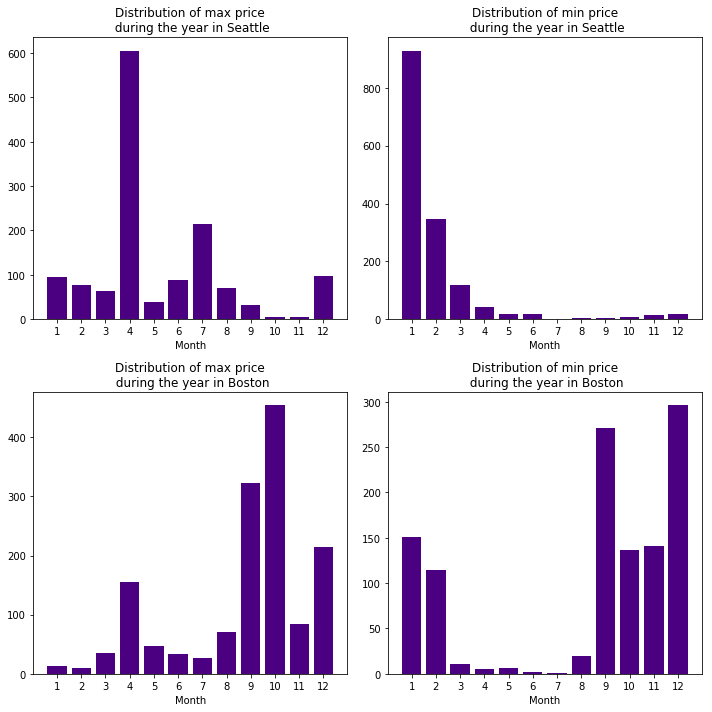

In [330]:
# plot density probabilities of max and min for Seattle and Boston
figure(figsize=(10,10))

values, counts = np.unique(df_cal_sea_ext['max'].dropna(), return_counts=True) # get months and the number of their occurence in the max column
plt.subplot(2,2,1)
plt.bar(values, counts, align='center', color='Indigo')
plt.gca().set_xticks(values)
plt.xlabel('Month')
plt.title('Distribution of max price\n during the year in Seattle')
#plt.show()

values, counts = np.unique(df_cal_sea_ext['min'].dropna(), return_counts=True) # get months and the number of their occurence in the min column
plt.subplot(2,2,2)
plt.bar(values, counts, align='center', color='Indigo')
plt.gca().set_xticks(values)
plt.xlabel('Month')
plt.title('Distribution of min price\n during the year in Seattle')
#plt.show()

values, counts = np.unique(df_cal_bos_ext['max'].dropna(), return_counts=True)
plt.subplot(2,2,3)
plt.bar(values, counts, align='center', color='Indigo')
plt.gca().set_xticks(values)
plt.xlabel('Month')
plt.title('Distribution of max price\n during the year in Boston')
#plt.show()

values, counts = np.unique(df_cal_bos_ext['min'].dropna(), return_counts=True)
plt.subplot(2,2,4)
plt.bar(values, counts, align='center', color='Indigo')
plt.gca().set_xticks(values)
plt.xlabel('Month')
plt.title('Distribution of min price\n during the year in Boston')

plt.tight_layout()
plt.show()

From the graphs above, it can be seen that the maximum and minimum prices for Seattle have well defined distributions, with peaks respectively for April and January. On the other side, the situation for Boston is not as easy to read, as the prices tend to be higher during September and October, albeit in the same months there are also a lot of listings with the lowest price (September is the second month with the highest number of listings for both maximum and minimum price). 

## 2. Average Price vs Neighbourhood and Accomodation Type

To answer this question, I'm going to look at the _listings_ datasets. These datasets contain a series of listings along with various information like price, host personal information, amenities, neighbourhood, accomodation type, etc. 

In [331]:
# read in Seattle dataset
df_lis = pd.read_csv('.\Seattle\listings.csv')
df_lis.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [332]:
# read in Boston dataset
df_lis_bos = pd.read_csv('.\Boston\listings.csv')
df_lis_bos.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

I'm interested, for the moment, in the __price__, __neighbourhood__ and __room_type__ features, as I want to analyze the variation in average price between different neighbourhoods and room types. Concerning the neighbourhood, there are three columns that contain information about neighbourhood (__neighbourhood__, __neigbourhood_cleansed__, __neigbourhood_group_cleansed__). It appears each of them list neighbrouhoods with a different level of detail. Let's look at their unique values for the two cities. 

In [333]:
# Seattle
print(df_lis['neighbourhood'].unique(), '\n\n', df_lis['neighbourhood_cleansed'].unique(), '\n\n', df_lis['neighbourhood_group_cleansed'].unique())

['Queen Anne' nan 'Ballard' 'Phinney Ridge' 'Fremont' 'Lower Queen Anne'
 'Westlake' 'Wallingford' 'Green Lake' 'Minor' 'Madrona'
 'Harrison/Denny-Blaine' 'Leschi' 'University District' 'Roosevelt'
 'Madison Park' 'Capitol Hill' 'Atlantic' 'North Beacon Hill'
 'Central Business District' 'Pike Place Market' 'Pike Market' 'Eastlake'
 'Portage Bay' 'South Lake Union' 'Magnolia' 'Belltown'
 'International District' 'Yesler Terrace' 'First Hill' 'Pioneer Square'
 'Gatewood' 'The Junction' 'Arbor Heights' 'Alki' 'North Admiral'
 'Crown Hill' 'Genesee' 'Fairmount Park' 'Interbay' 'Industrial District'
 'Holly Park' 'South Beacon Hill' 'Greenwood' 'Bitter Lake' 'Fauntleroy'
 'Mount Baker' 'Columbia City' 'Seward Park' 'Brighton' 'South Delridge'
 'Highland Park' 'High Point' 'View Ridge' 'Windermere' 'Dunlap'
 'Rainier Beach' 'North Delridge' 'Maple Leaf' 'Bryant' 'Ravenna'
 'Wedgewood' 'Riverview' 'Montlake' 'Broadway' 'Stevens' 'Victory Heights'
 'Mathews Beach' 'Cedar Park' 'Meadowbrook' '

In [334]:
# Boston
print(df_lis_bos['neighbourhood'].unique(), '\n\n', df_lis_bos['neighbourhood_cleansed'].unique(), '\n\n', df_lis_bos['neighbourhood_group_cleansed'].unique())

['Roslindale' nan 'Jamaica Plain' 'Mission Hill' 'Fenway/Kenmore'
 'Back Bay' 'Leather District' 'Chinatown' 'Hyde Park' 'North End'
 'Roxbury' 'South End' 'Mattapan' 'East Boston' 'South Boston'
 'Charlestown' 'West End' 'Beacon Hill' 'Theater District'
 'Downtown Crossing' 'Downtown' 'Financial District' 'Government Center'
 'Allston-Brighton' 'West Roxbury' 'Chestnut Hill' 'Dorchester'
 'Brookline' 'Cambridge' 'Somerville' 'Harvard Square'] 

 ['Roslindale' 'Jamaica Plain' 'Mission Hill' 'Longwood Medical Area'
 'Bay Village' 'Leather District' 'Chinatown' 'North End' 'Roxbury'
 'South End' 'Back Bay' 'East Boston' 'Charlestown' 'West End'
 'Beacon Hill' 'Downtown' 'Fenway' 'Brighton' 'West Roxbury' 'Hyde Park'
 'Mattapan' 'Dorchester' 'South Boston Waterfront' 'South Boston'
 'Allston'] 

 [nan]


From the results above, it appears that for Seattle the __neighbourhood_cleansed__ column has more detailed information than the __neighbourhood__ column. The latter also contains nans, whereas the first doesn't. The column __neighbrouhood_group_cleansed__ contains aggregated information about neighbourhoods. In order to have a better understanding of how price differ according to neighbourhoods and to make visualizations more clear, I'll use this column to have information about neighbourhoods for Seattle.
For Boston, the __neighbourhood_group_cleansed__ column has all nan values. The __neighbourhood__ column has more detailed information, but also contains nan values, therefore I'll use the neighbourhood_cleansed column, which allows easier visualizations as well.
Regarding the __price__ column, its values are strings in both dataframes, therefore a conversion to floats is needed.

In [335]:
# create sub-dataset of Seattle
df_lis_compare = df_lis[['neighbourhood_group_cleansed', 'room_type', 'price']]
# convert price column into float
df_lis_compare.loc[:,'price'] = df_lis_compare['price'].str.replace('$', '').str.replace(',', '').astype(float)

# create sub-dataset of Boston
df_lis_bos_compare = df_lis_bos[['neighbourhood_cleansed', 'room_type', 'price']]
# convert price column into float
df_lis_bos_compare.loc[:,'price'] = df_lis_bos_compare['price'].str.replace('$', '').str.replace(',', '').astype(float)
df_lis_bos_compare.head()

C:\Users\Duratorre\Anaconda\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,neighbourhood_cleansed,room_type,price
0,Roslindale,Entire home/apt,250.0
1,Roslindale,Private room,65.0
2,Roslindale,Private room,65.0
3,Roslindale,Private room,75.0
4,Roslindale,Private room,79.0


Let's check now for null values in the two dataframes.

In [336]:
df_lis_compare.isna().mean(), df_lis_bos_compare.isna().mean()

(neighbourhood_group_cleansed    0.0
 room_type                       0.0
 price                           0.0
 dtype: float64, neighbourhood_cleansed    0.0
 room_type                 0.0
 price                     0.0
 dtype: float64)

No nans are present in the two dataframes, so let's proceed to calculate the average price based on neighbourhood and accomodation type. 

### Results

I'll use again the _pivot table_ method to have a table with average prices as values and neighbourhoods as the index and accomodation type as columns.

#### Seattle

In [372]:
df_lis_plot = df_lis_compare.pivot_table(values='price', index='neighbourhood_group_cleansed', 
                                         columns='room_type', aggfunc=np.nanmean)
df_lis_plot.index.name = None # reomve index name
df_lis_plot.head()

room_type,Entire home/apt,Private room,Shared room
Ballard,156.925676,66.487805,NaN
Beacon Hill,126.175439,66.362069,43.333333
Capitol Hill,154.005208,91.832168,44.400000
Cascade,162.354839,89.708333,83.333333
Central Area,160.577778,78.492857,59.500000


Text(0, 0.5, 'Price')

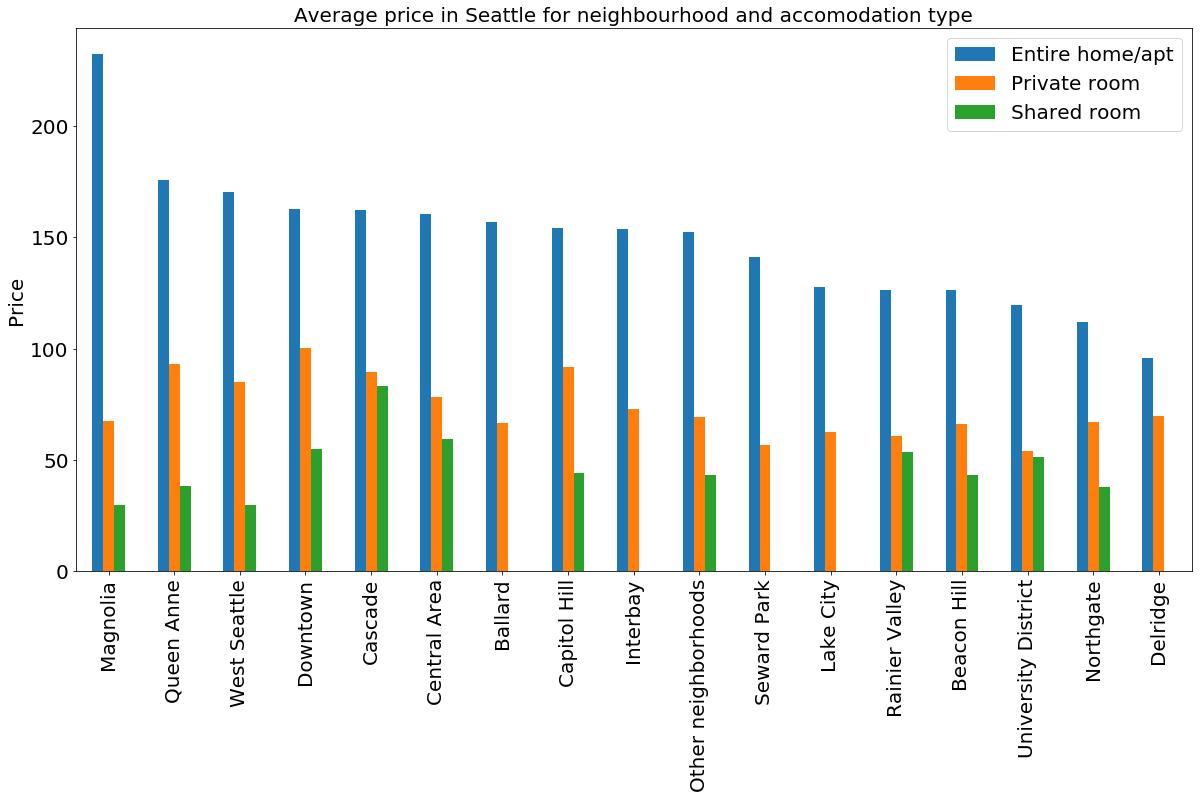

In [373]:
df_lis_plot.sort_values(by='Entire home/apt', ascending=False).plot.bar(figsize=(20,10), legend=False, fontsize=20)#, 
plt.title("Average price in Seattle for neighbourhood and accomodation type", fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('Price', fontsize=20)

It is possible to see from the graph above that, as one should expect, prices of an entire home or apartment are greater than those for a private or shared room. Regarding the private and shared room, the price for the first is higher than the second one. A noticeable thing is the fact that for those neighbourhoods that have the greatest average price for entire homes or apartment, not the same can be said about private or shared rooms. For istance, while Magnolia has the most expensive entire home and apartments on average, the most expensive private rooms are in Downtown and the most expensive shared room are in Cascade.

The average prices in the different neigbourhoods may be affected by outliers, reesulting in a neighbourhood being more expensive or cheaper than what it actually is. For example, in one neighbouhood I could have a few llisting with very high price that result the neighbourhood to have  large average price, despite the majority of its listings being on a medium range price. Let's check for outliers in the price of entire homes/apartments using a boxplot. 

Text(0.5, 1.0, 'Boxplots of price grouped by neighbourhood')

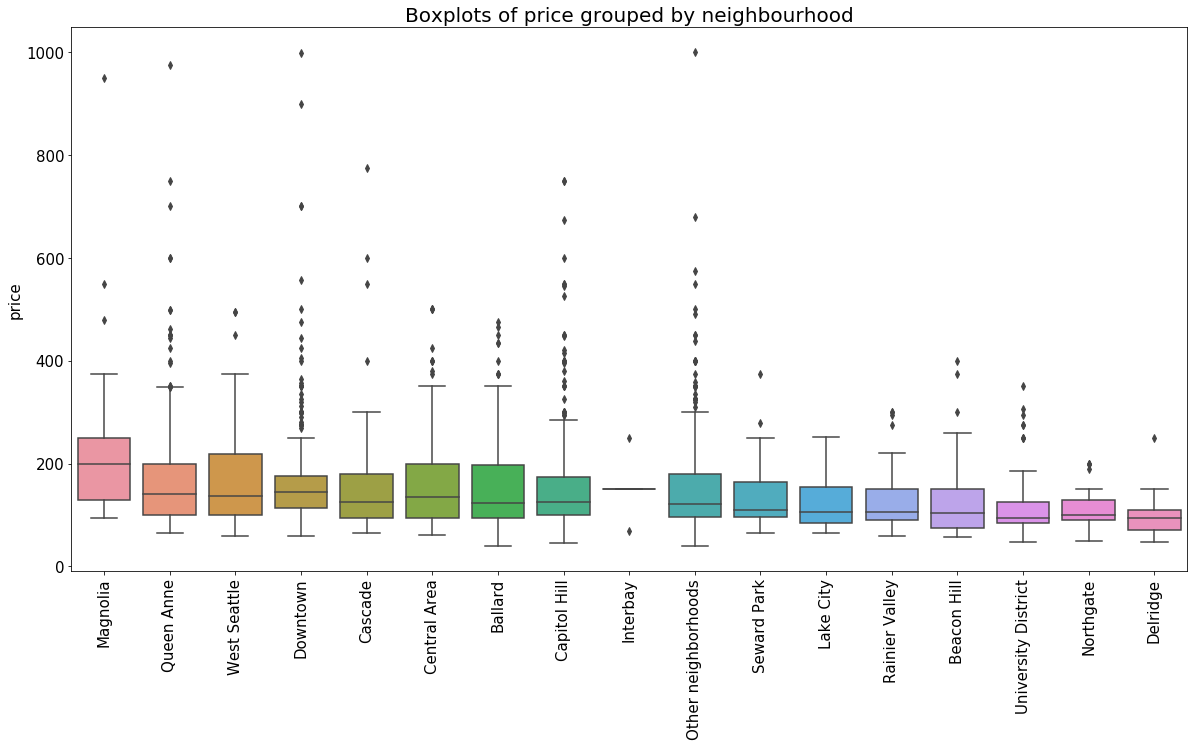

In [400]:
figure(figsize=(20,10))
df_lis_box = df_lis_compare[df_lis_compare.room_type == 'Entire home/apt']
df_lis_sort = df_lis_box.groupby(['neighbourhood_group_cleansed']).mean().sort_values(by='price', ascending=False)

# make a boxplot
sns.boxplot(y='price', x='neighbourhood_group_cleansed', data=df_lis_box, order=df_lis_sort.index) 
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('price', fontsize=15)
plt.xlabel('')
plt.title('Boxplots of price grouped by neighbourhood', fontsize=20)

The figure above shows the presence of outliers, the majority of them being extreme outliers above the upper limit. It can be seen that in some cases, the presence of outliers affects the order in which neighbourhoods are sorted. For example, Queen Anne and West Seattle have approximately the same median, with the interquartile range being greater for the second; without the presence of outliers, it would be very likely that West Seattle would have a greater average price than Queen Anne. The presence of outliers, however, determines that Queen Anne is more expensive than West Seattle on average.

#### Boston

In [37]:
df_lis_bos_plot = df_lis_bos_compare.pivot_table(values='price', index='neighbourhood_cleansed', 
                                         columns='room_type', aggfunc=np.nanmean)

df_lis_bos_plot.index.name = None
df_lis_bos_plot.head()

room_type,Entire home/apt,Private room,Shared room
Allston,175.510204,73.756410,82.333333
Back Bay,255.076046,152.333333,66.000000
Bay Village,299.550000,103.250000,NaN
Beacon Hill,241.580645,160.527778,106.000000
Brighton,163.053333,88.417476,90.857143


Text(0, 0.5, 'Price')

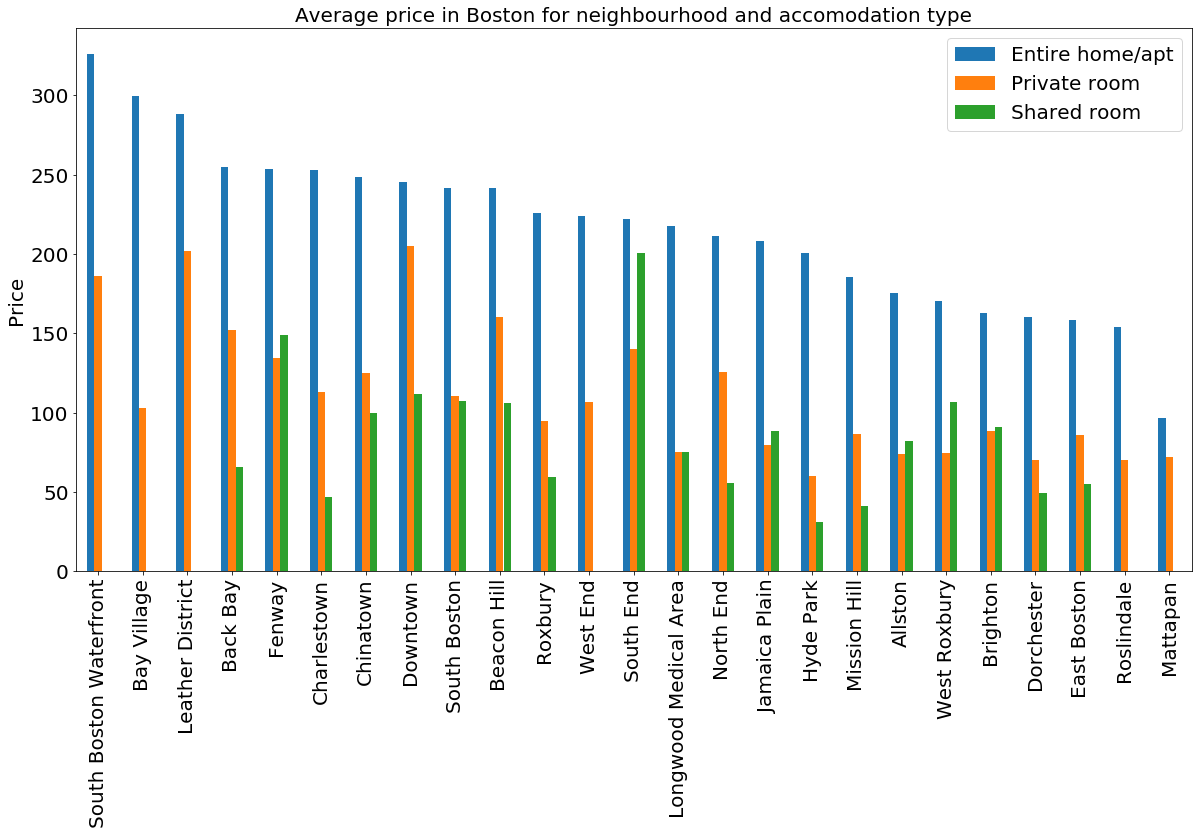

In [45]:
df_lis_bos_plot.sort_values(by='Entire home/apt', ascending=False).plot.bar(figsize=(20,10), fontsize=20) 
plt.title("Average price in Boston for neighbourhood and accomodation type", fontsize=20)
plt.legend(fontsize=20)
plt.ylabel('Price', fontsize=20)

Text(0.5, 1.0, 'Boxplots of price grouped by neighbourhood')

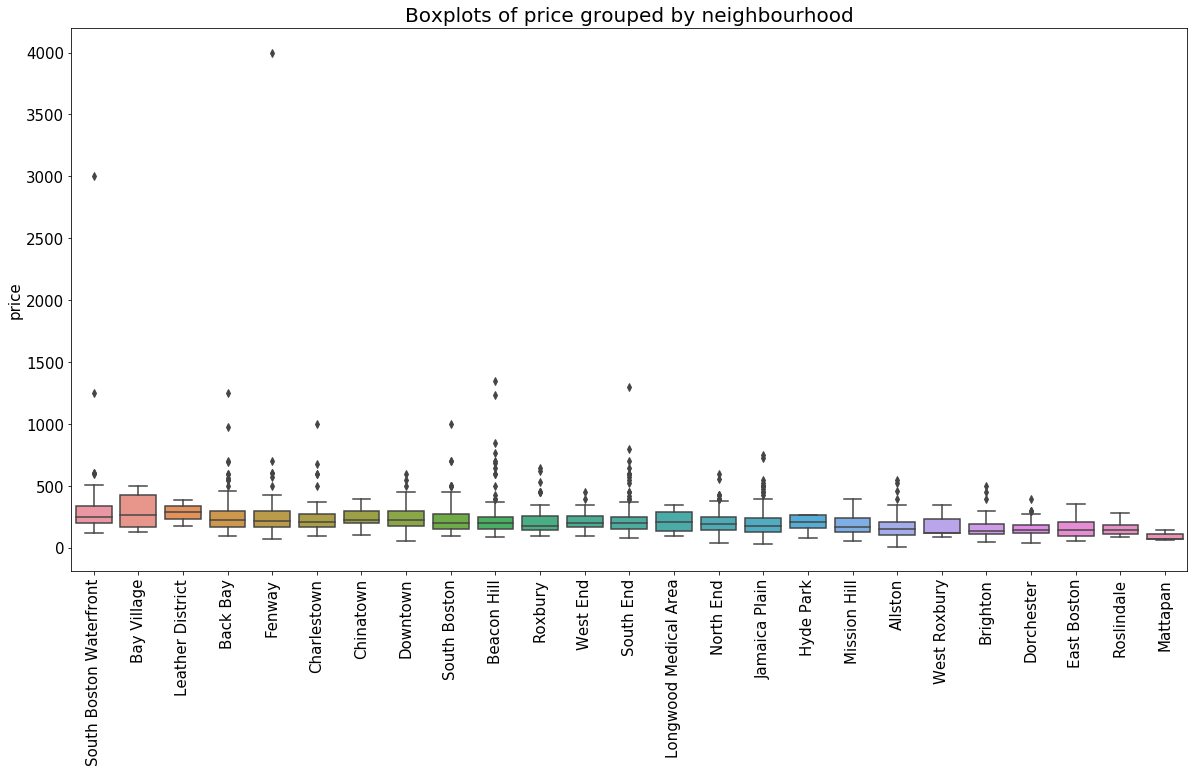

In [404]:
figure(figsize=(20,10))
df_lis_bos_box = df_lis_bos_compare[df_lis_bos_compare.room_type == 'Entire home/apt']
df_lis_bos_sort = df_lis_bos_box.groupby(['neighbourhood_cleansed']).mean().sort_values(by='price', ascending=False)

# make a boxplot
sns.boxplot(y='price', x='neighbourhood_cleansed', data=df_lis_bos_box, order=df_lis_bos_sort.index) 
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('price', fontsize=15)
plt.xlabel('')
plt.title('Boxplots of price grouped by neighbourhood', fontsize=20)

Looking at the results for Boston, the conclusions are almost the same as Seattle, with the only difference being that in Boston there are some neighbourhoods where the average price of private rooms is lower compared to shared rooms. Regarding the outliers, it is possible to see that for the neighbourhood Fenway, the presence of an outlier with a very high price (around 4000) makes on average the neighbourhood one of the most expensive, whereas it's median and interquartile range suggests that it could be lower in order than Downtown.

## 3. Correlation of price and ratings

To check if there is correlation between these two variables, it is better first to isolate them into a separate dataframe. After that, I'm going to perform proper data type conversion for price like before, and finally use a scatter plot of the two variables to check their behaviour against each other. 

In [360]:
# Seattle
# create sub-dataframe of price and rating
df_lis_scatter = df_lis[['price', 'review_scores_rating']]
# convert price to float
df_lis_scatter.loc[:,'price'] = df_lis_scatter['price'].str.replace('$', '').str.replace(',', '').astype(float)
# drop null values
df_lis_scatter.dropna(inplace=True)

# Boston
df_lis_bos_scatter = df_lis_bos[['price', 'review_scores_rating']]
df_lis_bos_scatter.loc[:,'price'] = df_lis_bos_scatter['price'].str.replace('$', '').str.replace(',', '').astype(float)
df_lis_bos_scatter.dropna(inplace=True)

C:\Users\Duratorre\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


(array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.]),
 <a list of 11 Text yticklabel objects>)

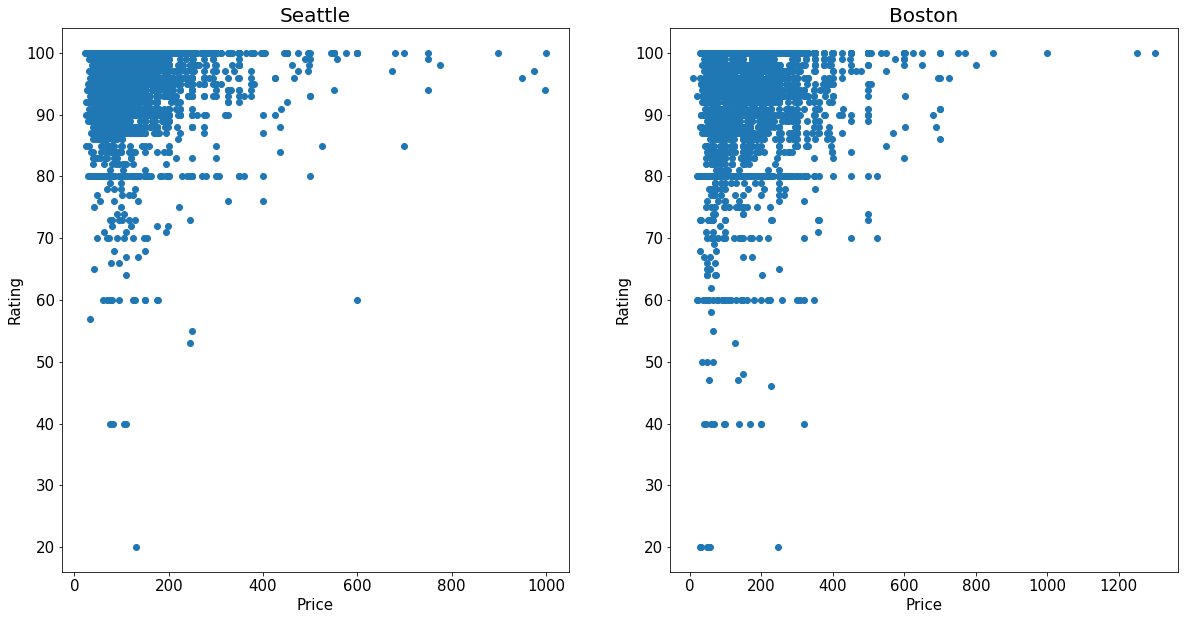

In [361]:
# making the plots
# Seattle
figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(df_lis_scatter['price'], df_lis_scatter['review_scores_rating'])
plt.title('Seattle', fontsize=20)
plt.xlabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.yticks(fontsize=15)

# Boston
plt.subplot(1,2,2)
plt.scatter(df_lis_bos_scatter['price'], df_lis_bos_scatter['review_scores_rating'])
plt.title('Boston', fontsize=20)
plt.xlabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.yticks(fontsize=15)

We can say from the pictures above that price and rating are not really correlated. The only noticeable thing is that for higher prices ratings tend to be higher, while for low prices ratings have multiple values. This could lead to the conclusion that rating affects price, rather than viceversa.

## 4. Predict house prices

Last step of the analysis revolves around predicting house prices. The data necessary for this analisys are contained in the listing _datasets_. In order to run a predicting model on the data, it is first necessary to make it ready for analysis. There a lot of columns in the _listings_ dataframes that contains urls. These urls can't be used to predict price, therefore need to be discarded.

In [424]:
# remove all columns with url
df_lis = df_lis.loc[:, ~df_lis.columns.str.contains('url', case = False)]
df_lis.head()
df_lis.dtypes

id                                    int64
scrape_id                             int64
last_scraped                         object
name                                 object
summary                              object
space                                object
description                          object
experiences_offered                  object
neighborhood_overview                object
notes                                object
transit                              object
host_id                               int64
host_name                            object
host_since                           object
host_location                        object
host_about                           object
host_response_time                   object
host_response_rate                   object
host_acceptance_rate                 object
host_is_superhost                    object
host_neighbourhood                   object
host_listings_count                 float64
host_total_listings_count       

In [425]:
df_lis[df_lis.bathrooms.isna()]

,id,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1242,19611,20160104002432,2016-01-04,1 Bedroom Downtown Seattle Oasis,This central unit is perfect for anyone lookin...,Seattle Oasis Vacations proudly offer this wel...,This central unit is perfect for anyone lookin...,none,NaN,NaN,NaN,74305,Darik,2010-01-27,"Kent, Washington, United States","My wife, Sally and I are excited for you to st...",within a few hours,94%,100%,f,Belltown,34.0,34.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"3rd Ave, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.615611,-122.345927,t,Apartment,Entire home/apt,4,NaN,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""W...",NaN,$107.00,NaN,NaN,NaN,$96.00,1,$0.00,2,365,today,t,22,46,76,151,2016-01-04,26,2010-03-23,2015-11-12,87.0,9.0,9.0,10.0,9.0,9.0,8.0,f,NaN,WASHINGTON,f,strict,t,t,6,0.37
1314,59827,20160104002432,2016-01-04,1 Bedroom Sweeping View Oasis,NaN,"Welcome to Seattle Oasis Vacations, your home ...","Welcome to Seattle Oasis Vacations, your home ...",none,NaN,NaN,NaN,74305,Darik,2010-01-27,"Kent, Washington, United States","My wife, Sally and I are excited for you to st...",within a few hours,94%,100%,f,Belltown,34.0,34.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"3rd Ave, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.616274,-122.344126,t,Apartment,Entire home/apt,4,NaN,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""W...",NaN,$135.00,NaN,NaN,NaN,$96.00,1,$0.00,2,365,today,t,24,54,84,204,2016-01-04,13,2010-12-24,2015-12-20,87.0,9.0,9.0,9.0,9.0,9.0,8.0,f,NaN,WASHINGTON,t,strict,t,t,6,0.21
1357,19623,20160104002432,2016-01-04,2 Bedroom Downtown Seattle Oasis,NaN,Seattle Oasis Vacations proudly offer this wel...,Seattle Oasis Vacations proudly offer this wel...,none,NaN,NaN,NaN,74305,Darik,2010-01-27,"Kent, Washington, United States","My wife, Sally and I are excited for you to st...",within a few hours,94%,100%,f,Belltown,34.0,34.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"3rd Ave, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.616430,-122.346344,t,Apartment,Entire home/apt,6,NaN,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""W...",NaN,$186.00,NaN,NaN,NaN,$107.00,1,$0.00,2,1825,today,t,25,53,83,172,2016-01-04,38,2010-03-23,2015-10-25,89.0,9.0,9.0,9.0,9.0,9.0,8.0,f,NaN,WASHINGTON,t,strict,t,t,6,0.54
1378,224763,20160104002432,2016-01-04,"SALE! WiFi Luxurious, Parking Inc",Last minute mid week sale!!!,Luxurious condominium in Seattle's best locati...,Last minute mid week sale!!!

Some of the columns may have unique values, like __country__, and __country_code__. If a colum  has unique values, it does not provide any useful information to the model for predicting prices, therefore it can be removed from the dataframe. 

In [426]:
# remove columns with unique values
unique_values = []
for col in list(df_lis.columns):
    if df_lis[col].unique().size==1:
        unique_values.append(col)

unique_values.remove('last_scraped')
print(unique_values)

df_lis_no_unique = df_lis.drop(columns=unique_values)
#df_lis_no_unique.columns

['scrape_id', 'experiences_offered', 'market', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names']


Now some columns are left that provide no relevant information to predict price. These columns are those that contain data like personal information about the host, as these do not affect house price, which is a value decided by the host themselves, house description, zipcode, weekly price and monthly price, as I'm interested in just the daily price, and city and state, as these two columns contain data that can be conducted to unique values for each column. Let's remove the columns.

In [427]:
# remove unnecessary columns
unnec_col = ['summary', 'space', 'description','name', 'host_id', 'host_name', 'host_location', 'host_about', 
             'host_neighbourhood', 'neighborhood_overview', 'neighbourhood', 'neighbourhood_cleansed', 'notes', 
             'street', 'city', 'state', 'zipcode', 'smart_location', 'latitude', 'longitude', 
             'weekly_price', 'monthly_price', 'host_acceptance_rate', 'calendar_updated']

#keep_col = ['host_acceptance_rate', 'host_since', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'availability_30', 'availability_60', 'availability_90', 
#             'availability_365', 'review_scores_accuracy', 'review_scores_cleanliness', 
#             'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 
#            'first_review', 'last_review', 'calendar_updated']

df_lis_no_unn = df_lis_no_unique.drop(columns=unnec_col)
df_lis_no_unn.head()

,id,last_scraped,transit,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,2016-01-04,NaN,2011-08-11,within a few hours,96%,f,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,2,$5.00,1,365,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,953595,2016-01-04,"Convenient bus stops are just down the block, ...",2013-02-21,within an hour,98%,t,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,$100.00,$40.00,1,$0.00,2,90,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,3308979,2016-01-04,A bus stop is just 2 blocks away. Easy bus a...,2014-06-12,within a few hours,67%,f,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,Queen Anne,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$975.00,"$1,000.00",$300.00,10,$25.00,4,30,1,6,17,220,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15
3,7421966,2016-01-04,NaN,2013-11-06,NaN,NaN,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Queen Anne,t,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN,$100.00,NaN,NaN,1,$0.00,1,1125,0,0,0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
4,278830,2016-01-04,The nearest public transit bus (D Line) is 2 b...,2011-11-29,within an hour,100%,f,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,Queen Anne,t,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,$450.00,$700.00,$125.00,6,$15.00,1,1125,30,60,90,365,38,2012-07-10,2015-10-24,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,f,f,1,0.89


Let's check now the amount of null values in each column.

In [428]:
#print(df_lis_no_unn.columns)
print(df_lis_no_unn.isna().mean())

id                                  0.000000
last_scraped                        0.000000
transit                             0.244631
host_since                          0.000524
host_response_time                  0.136983
host_response_rate                  0.136983
host_is_superhost                   0.000524
host_listings_count                 0.000524
host_total_listings_count           0.000524
host_verifications                  0.000000
host_has_profile_pic                0.000524
host_identity_verified              0.000524
neighbourhood_group_cleansed        0.000000
is_location_exact                   0.000000
property_type                       0.000262
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.004191
bedrooms                            0.001572
beds                                0.000262
bed_type                            0.000000
amenities                           0.000000
square_fee

The column __square_feet__ has a lot of null values (more than 97%). Therefore it's best to discard it. Other columns, like __review_scores_rating__ , __host_response_rate__ and __review_scores_accuracy__ have some null values. For __review_scores_rating__ and __host_response_rate__, the null values are very likely associated with new hosts, as they still haven't hosted anyone in their accodomodation nor received any inquiries yet, and therefore these values can't be calculated. I'm going to delete those rows with null values for any of these columns, without computing any null vaues, which I won't be considering new hosts into the analysis.

In [429]:
# dropping columns with majority on nan values, like square_feet 
df_lis_new = df_lis_no_unn.drop(columns=['square_feet'])

# dropping rows with nans in revie_scores_ratings, host_response_rate and review_scores_accuracy
df_lis_new.dropna(axis=0, how='any', subset=['review_scores_rating'], inplace=True)
df_lis_new.dropna(axis=0, how='any', subset=['host_response_rate'], inplace=True) 
df_lis_new.dropna(axis=0, how='any', subset=['review_scores_accuracy'], inplace=True)

Let's check once again the amount of nulls left in the dataframe for each column.

In [430]:
df_lis_new.head()
df_lis_new.isna().mean()
#df_lis_new.shape

id                                  0.000000
last_scraped                        0.000000
transit                             0.198457
host_since                          0.000000
host_response_time                  0.000000
host_response_rate                  0.000000
host_is_superhost                   0.000000
host_listings_count                 0.000000
host_total_listings_count           0.000000
host_verifications                  0.000000
host_has_profile_pic                0.000000
host_identity_verified              0.000000
neighbourhood_group_cleansed        0.000000
is_location_exact                   0.000000
property_type                       0.000000
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.004208
bedrooms                            0.002104
beds                                0.000000
bed_type                            0.000000
amenities                           0.000000
price     

The only columns left with nans are __transit__,  __bathrooms__, __bedrooms__, __security_deposit__ and __cleaning_fee__. The column transit will be dealt with later on. For the __bathrooms__, __bedrooms__, __security_deposit__ and __cleaning_fee__ columns I'm going to compute the null values. For bedrooms we are going to put 0, as it is very likely that the listings without information about bedrooms are those that do not have one. The same goes for security deposit and cleaning fees: when these values are not present, it's probably because they are 0. For bathrooms the reasoning is slightly different: as there is no house without a bathrooms, I'm going to set the null to 1. 

In [431]:
df_lis_new.loc[:,'host_response_rate'] = df_lis_new['host_response_rate'].str.replace('%', '').astype(float)
df_lis_new.loc[:,'price'] = df_lis_new['price'].str.replace('$', '').astype(float)
df_lis_new.loc[:,'security_deposit'] = df_lis_new['security_deposit'].str.replace('$', '').str.replace(',', '').astype(float)
df_lis_new.loc[:,'cleaning_fee'] = df_lis_new['cleaning_fee'].str.replace('$', '').astype(float)
df_lis_new.loc[:,'extra_people'] = df_lis_new['extra_people'].str.replace('$', '').astype(float)
df_lis_new.replace('t', 1, inplace=True)
df_lis_new.replace('f', 0, inplace=True)
df_lis_new['bedrooms'].fillna(0, inplace=True) # as there can be homes w/o bedrooms
df_lis_new['bathrooms'].fillna(1, inplace=True) # all houses are entire building apartments or single rooms, there has to be a bathroom
df_lis_new['security_deposit'].fillna(0, inplace=True)
df_lis_new['cleaning_fee'].fillna(0, inplace=True)

df_lis_new.head()

,id,last_scraped,transit,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,2016-01-04,NaN,2011-08-11,within a few hours,96.0,0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,moderate,0,0,2,4.07
1,953595,2016-01-04,"Convenient bus stops are just down the block, ...",2013-02-21,within an hour,98.0,1,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,1,1,6,1.48
2,3308979,2016-01-04,A bus stop is just 2 blocks away. Easy bus a...,2014-06-12,within a few hours,67.0,0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1,1,Queen Anne,1,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,1000.0,300.0,10,25.0,4,30,1,6,17,220,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,0,0,2,1.15
4,278830,2016-01-04,The nearest public transit bus (D Line) is 2 b...,2011-11-29,within an hour,100.0,0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,Queen Anne,1,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,700.0,125.0,6,15.0,1,1125,30,60,90,365,38,2012-07-10,2015-10-24,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,strict,0,0,1,0.89
6,1909058,2016-01-04,The bus goes through the lower Queen Anne neig...,2012-05-30,within an hour,100.0,1,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",80.0,150.0,0.0,1,10.0,3,14,20,49,71,346,58,2014-01-27,2015-12-07,99.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,0,0,1,2.46


The next action regards feature engineering. There are still columns with date values. I need to create features out of these columns that can be used for the analysis. The columns with date values are __last_scraped__, __host_since__, __first_review__ and __last_review__, which contain dates respectively about the last day the data was extracted, the day since the host joined AirBnB, and the dates of first and last review for each listing. I can use the information from these columns to calculate values such as the host seniority, e.g. the number of days the host has been such at the day of the data extraction, and the days from first and last review for each listing.

In [432]:
# create new features
df_lis_clean = df_lis_new
df_lis_clean['host_seniority'] = (pd.to_datetime(df_lis_new['last_scraped']) - pd.to_datetime(df_lis_new['host_since'])).dt.days
df_lis_clean['days_since_first_review'] = (pd.to_datetime(df_lis_new['last_scraped']) - pd.to_datetime(df_lis_new['first_review'])).dt.days
df_lis_clean['days_since_last_review'] = (pd.to_datetime(df_lis_new['last_scraped']) - pd.to_datetime(df_lis_new['last_review'])).dt.days
df_lis_clean.drop(columns=['last_scraped', 'host_since', 'first_review', 'last_review'], inplace = True)
df_lis_clean.head()

,id,transit,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_seniority,days_since_first_review,days_since_last_review
0,241032,NaN,within a few hours,96.0,0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,moderate,0,0,2,4.07,1607,1525,2
1,953595,"Convenient bus stops are just down the block, ...",within an hour,98.0,1,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,1,1,6,1.48,1047,868,6
2,3308979,A bus stop is just 2 blocks away. Easy bus a...,within a few hours,67.0,0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1,1,Queen Anne,1,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,1000.0,300.0,10,25.0,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,0,0,2,1.15,571,523,123
4,278830,The nearest public transit bus (D Line) is 2 b...,within an hour,100.0,0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,Queen Anne,1,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,700.0,125.0,6,15.0,1,1125,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,strict,0,0,1,0.89,1497,1273,72
6,1909058,The bus goes through the lower Queen Anne neig...,within an hour,100.0,1,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",80.0,150.0,0.0,1,10.0,3,14,20,49,71,346,58,99.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,0,0,1,2.46,1314,707,28


Check if there are nans left

In [433]:
df_lis_clean.dtypes

id                                    int64
transit                              object
host_response_time                   object
host_response_rate                  float64
host_is_superhost                     int64
host_listings_count                 float64
host_total_listings_count           float64
host_verifications                   object
host_has_profile_pic                  int64
host_identity_verified                int64
neighbourhood_group_cleansed         object
is_location_exact                     int64
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
amenities                            object
price                               float64
security_deposit                    float64
cleaning_fee                    

In [434]:
df_lis_clean.isna().mean()

id                                  0.000000
transit                             0.198457
host_response_time                  0.000000
host_response_rate                  0.000000
host_is_superhost                   0.000000
host_listings_count                 0.000000
host_total_listings_count           0.000000
host_verifications                  0.000000
host_has_profile_pic                0.000000
host_identity_verified              0.000000
neighbourhood_group_cleansed        0.000000
is_location_exact                   0.000000
property_type                       0.000000
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.000000
bedrooms                            0.000000
beds                                0.000000
bed_type                            0.000000
amenities                           0.000000
price                               0.000000
security_deposit                    0.000000
cleaning_f

In [216]:
# I CAN DELETE THIS

def extract_features(df, column_names):
    '''
    This function reproduces one hot encoding for those columns of a pandas dataframe that have a set or list of values 
    in each row
    
    Input:
    df - a pandas dataframe 
    column_names - a list of columns whose values are sets or lists
    
    Output:
    new_df - a dataframe with one hot encoding for the selected column
    '''
    
    # create a set of the distinct values contained in df[column_name]
    for column in column_names:
        item_set = set()
        for item in df[column]:
            item = re.sub(r"[^a-zA-Z0-9\,\/\-]", "", item)
            item = item.split(',')
            new_entry = set(item)
            item_set.update(new_entry)
    
    # remove any white spaces or None
        try:
            item_set.remove('')
        except:
            pass
        try:
            item_set.remove('None')
        except:
            pass

    # one hot encoding of df[column_name]
        for item in list(item_set):  #[:-1]:
            booleans = df[column].str.contains(item)
            new_col = [int(boolean) for boolean in booleans]
            new_col_name = '{}_{}'.format(column, item)
            df[new_col_name] = new_col
        
    # remove original columns from dataframe df
    new_df = df.drop(columns = column_names)
    
    return new_df

In [441]:
#def get_values(value):
#    values = re.sub(r"[^a-zA-Z0-9\,\/\-]", "", value)
#    return values

extract_features = ['amenities', 'host_verifications']

df_lis_try = df_lis_clean

for col in extract_features:
    features = df_lis_try[col].apply(lambda x: re.sub(r"[^a-zA-Z0-9\,\/\-]", "", x))
    features_onehot = features.str.get_dummies(sep=',').add_prefix(col + '_')
    df_lis_try = pd.concat((df_lis_try, features_onehot), axis=1)
    print(col)

df_lis_try.head()

amenities
host_verifications


,id,transit,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_seniority,days_since_first_review,days_since_last_review,amenities_24-HourCheck-in,amenities_AirConditioning,amenities_Breakfast,amenities_Buzzer/WirelessIntercom,amenities_CableTV,amenities_CarbonMonoxideDetector,amenities_Cats,amenities_Dogs,amenities_Doorman,amenities_Dryer,amenities_ElevatorinBuilding,amenities_Essentials,amenities_Family/KidFriendly,amenities_FireExtinguisher,amenities_FirstAidKit,amenities_FreeParkingonPremises,amenities_Gym,amenities_HairDryer,amenities_Hangers,amenities_Heating,amenities_HotTub,amenities_IndoorFireplace,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_LaptopFriendlyWorkspace,amenities_LockonBedroomDoor,amenities_Otherpets,amenities_PetsAllowed,amenities_Petsliveonthisproperty,amenities_Pool,amenities_SafetyCard,amenities_Shampoo,amenities_SmokeDetector,amenities_SmokingAllowed,amenities_SuitableforEvents,amenities_TV,amenities_Washer,amenities_Washer/Dryer,amenities_WheelchairAccessible,amenities_WirelessInternet,host_verifications_amex,host_verifications_email,host_verifications_facebook,host_verifications_google,host_verifications_jumio,host_verifications_kba,host_verifications_linkedin,host_verifications_manualoffline,host_verifications_manualonline,host_verifications_phone,host_verifications_photographer,host_verifications_reviews,host_verifications_sentid,host_verifications_weibo
0,241032,NaN,within a few hours,96.0,0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,moderate,0,0,2,4.07,1607,1525,2,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0
1,953595,"Convenient bus stops are just down the block, ...",within an hour,98.0,1,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,1,1,6,1.48,1047,868,6,0,0,0,1,0,1,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0
2,3308979,A bus stop is just 2 blocks away. Easy bus a...,within a few hours,67.0,0,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",1,1,Queen Anne,1,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,1000.0,300.0,10,25.0,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,0,0,2,1.15,571,523,123,0,1,0,0,1,1,1,1,0,1,0,1,1,0,0,1,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0
4,278830,The nearest public transit bus (D Line) is 2 b...,within an hour,100.0,0,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,Queen Anne,1,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,700.0,125.0,6,15.0,1,1125,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,strict,0,0,1,0.89,1497,1273,72,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,

In [437]:
df_lis_try.head()

,id,transit,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_seniority,days_since_first_review,days_since_last_review,amenities_24-HourCheck-in,amenities_AirConditioning,amenities_Breakfast,amenities_Buzzer/WirelessIntercom,amenities_CableTV,amenities_CarbonMonoxideDetector,amenities_Cats,amenities_Dogs,amenities_Doorman,amenities_Dryer,amenities_ElevatorinBuilding,amenities_Essentials,amenities_Family/KidFriendly,amenities_FireExtinguisher,amenities_FirstAidKit,amenities_FreeParkingonPremises,amenities_Gym,amenities_HairDryer,amenities_Hangers,amenities_Heating,amenities_HotTub,amenities_IndoorFireplace,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_LaptopFriendlyWorkspace,amenities_LockonBedroomDoor,amenities_Otherpets,amenities_PetsAllowed,amenities_Petsliveonthisproperty,amenities_Pool,amenities_SafetyCard,amenities_Shampoo,amenities_SmokeDetector,amenities_SmokingAllowed,amenities_SuitableforEvents,amenities_TV,amenities_Washer,amenities_Washer/Dryer,amenities_WheelchairAccessible,amenities_WirelessInternet,host_verifications_24-HourCheck-in,host_verifications_AirConditioning,host_verifications_Breakfast,host_verifications_Buzzer/WirelessIntercom,host_verifications_CableTV,host_verifications_CarbonMonoxideDetector,host_verifications_Cats,host_verifications_Dogs,host_verifications_Doorman,host_verifications_Dryer,host_verifications_ElevatorinBuilding,host_verifications_Essentials,host_verifications_Family/KidFriendly,host_verifications_FireExtinguisher,host_verifications_FirstAidKit,host_verifications_FreeParkingonPremises,host_verifications_Gym,host_verifications_HairDryer,host_verifications_Hangers,host_verifications_Heating,host_verifications_HotTub,host_verifications_IndoorFireplace,host_verifications_Internet,host_verifications_Iron,host_verifications_Kitchen,host_verifications_LaptopFriendlyWorkspace,host_verifications_LockonBedroomDoor,host_verifications_Otherpets,host_verifications_PetsAllowed,host_verifications_Petsliveonthisproperty,host_verifications_Pool,host_verifications_SafetyCard,host_verifications_Shampoo,host_verifications_SmokeDetector,host_verifications_SmokingAllowed,host_verifications_SuitableforEvents,host_verifications_TV,host_verifications_Washer,host_verifications_Washer/Dryer,host_verifications_WheelchairAccessible,host_verifications_WirelessInternet
0,241032,NaN,within a few hours,96.0,0,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,moderate,0,0,2,4.07,1607,1525,2,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
1,953595,"Convenient bus stops are just down the block, ...",within an hour,98.0,1,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",1,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,1,1,6,1.48,1047,868,6,0,0,0,1,0,1,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,

In [217]:
# Extracting features from categorical columns

df_lis_feat = extract_features(df_lis_clean, ['amenities', 'host_verifications'])

one_hot_columns = ['host_response_time', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']
df_lis_ohe = pd.get_dummies(data = df_lis_feat, columns = one_hot_columns)  #, drop_first=True)
df_lis_ohe.head()
#df_lis_ohe.shape


,id,transit,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_seniority,days_since_first_review,days_since_last_review,amenities_Pool,amenities_Internet,amenities_LaptopFriendlyWorkspace,amenities_Dogs,amenities_HairDryer,amenities_Heating,amenities_Dryer,amenities_WirelessInternet,amenities_Hangers,amenities_Breakfast,amenities_SmokeDetector,amenities_Washer/Dryer,amenities_SuitableforEvents,amenities_IndoorFireplace,amenities_FireExtinguisher,amenities_Kitchen,amenities_FreeParkingonPremises,amenities_24-HourCheck-in,amenities_ElevatorinBuilding,amenities_Gym,amenities_TV,amenities_Family/KidFriendly,amenities_Doorman,amenities_SafetyCard,amenities_Otherpets,amenities_Buzzer/WirelessIntercom,amenities_AirConditioning,amenities_HotTub,amenities_CableTV,amenities_Washer,amenities_Iron,amenities_FirstAidKit,amenities_LockonBedroomDoor,amenities_CarbonMonoxideDetector,amenities_SmokingAllowed,amenities_Cats,amenities_WheelchairAccessible,amenities_Essentials,amenities_Petsliveonthisproperty,amenities_PetsAllowed,amenities_Shampoo,host_verifications_manualonline,host_verifications_amex,host_verifications_sentid,host_verifications_manualoffline,host_verifications_google,host_verifications_jumio,host_verifications_phone,host_verifications_email,host_verifications_linkedin,host_verifications_photographer,host_verifications_weibo,host_verifications_reviews,host_verifications_kba,host_verifications_facebook,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,241032,NaN,96.0,0,3.0,3.0,1,1,1,4,1.0,1.0,1.0,85.0,0.0,0.0,2,5.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,0,0,2,4.07,1607,1525,2,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
1,953595,"Convenient bus stops are just down the block, ...",98.0,1,6.0,6.0,1,1,1,4,1.0,1.0,1.0,150.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,1,6,1.

In [218]:
# One Hot Encoding for transportation

transport_means = ['Bus', 'Light Rail', 'Ferry', 'Heavy Rail', 'Train', 'Metro', 'NaN']

df_lis_ohe['transit'].fillna("NaN", inplace=True)

for mean in transport_means:  #[:-1]:
    booleans = df_lis_ohe['transit'].str.contains(mean, False)    #re.find(mean, 'hello', re.IGNORECASE)
    new_col = [int(boolean) for boolean in booleans]
    new_col_name = 'transit_{}'.format(mean)
    df_lis_ohe[new_col_name] = new_col

df_lis_ohe.drop(columns='transit', inplace=True)
df_lis_ohe.head()
df_lis_ohe.shape

(2852, 149)

In [227]:
df_lis_pred = df_lis_ohe.drop(columns='id')
df_lis_pred.head()
df_lis_pred.shape

(2852, 148)

### Let's do all the steps above for the listings dataset of Boston

In [113]:
# remove all columns with url
lis_bos = df_lis_bos.loc[:,~df_lis_bos.columns.str.contains('url', case = False)]

# remove columns with unique values
unique_values = []
for col in list(lis_bos.columns):
    if lis_bos[col].unique().shape[0]==1:
        unique_values.append(col)
    
print(unique_values)

lis_bos_nounq = lis_bos.drop(columns=unique_values)

# remove unnecessary columns
unnec_col = ['summary', 'space', 'description','access', 'interaction', 'house_rules', 'name', 'host_id', 'host_name', 
             'host_since', 'host_location', 'host_about', 'host_neighbourhood', 'neighborhood_overview', 'notes', 'street', 
             'neighbourhood_cleansed', 'city', 'zipcode', 'smart_location', 'latitude', 'longitude', 'weekly_price', 
             'monthly_price', 'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
             'first_review', 'last_review', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
             'review_scores_communication', 'review_scores_location', 'review_scores_value']

lis_bos_nec = lis_bos_nounq.drop(columns=unnec_col)

print(lis_bos_nec.columns)
print(lis_bos_nec.isna().mean())

# dropping columns with no relevance for price, as well as columns with majority on nan values, like 
lis_bos_new = lis_bos_nec.drop(columns=['host_acceptance_rate', 'square_feet'])

# dropping rows with no ratings, as we can't perform correlation on those values
lis_bos_new.dropna(axis=0, how='any', subset=['review_scores_rating'], inplace=True)

# taking rows where host_response_rate is not null
lis_bos_clean = lis_bos_new[~lis_bos_new['host_response_rate'].isnull()]
print(lis_bos_clean.isna().mean())
lis_bos_clean.head()

lis_bos_clean.loc[:,'host_response_rate'] = lis_bos_clean['host_response_rate'].str.replace('%', '').astype(float)
lis_bos_clean.loc[:,'price'] = lis_bos_clean['price'].str.replace('$', '').str.replace(',', '').astype(float)
#lis_bos_clean.loc[:,'price'] = lis_bos_clean['price'].str.replace(',', '').astype(float)
lis_bos_clean.loc[:,'security_deposit'] = lis_bos_clean['security_deposit'].str.replace('$', '').str.replace(',', '').astype(float)
#lis_bos_clean.loc[:,'security_deposit'] = lis_bos_clean['security_deposit'].str.replace(',', '').astype(float)
lis_bos_clean.loc[:,'cleaning_fee'] = lis_bos_clean['cleaning_fee'].str.replace('$', '').astype(float)
lis_bos_clean.loc[:,'extra_people'] = lis_bos_clean['extra_people'].str.replace('$', '').astype(float)

lis_bos_clean.replace('t', 1, inplace=True)
lis_bos_clean.replace('f', 0, inplace=True)

lis_bos_clean['bedrooms'].fillna(0, inplace=True) # as there can be homes w/o bedrooms
lis_bos_clean['bathrooms'].fillna(1, inplace=True) # all houses are entire building apartments or single rooms, there has to be a bathroom
lis_bos_clean['security_deposit'].fillna(0, inplace=True)
lis_bos_clean['cleaning_fee'].fillna(0, inplace=True)
lis_bos_clean['beds'].fillna(1, inplace=True)

print(lis_bos_clean.isna().mean())

# Extracting features from categorical columns

bos_lis_feat = extract_features(lis_bos_clean, ['amenities', 'host_verifications'])

one_hot_columns = ['host_response_time', 'neighbourhood', 'property_type', 'room_type', 'bed_type', 'cancellation_policy', 'market']
bos_lis_ohe = pd.get_dummies(data = bos_lis_feat, columns = one_hot_columns)  #, drop_first=True)
bos_lis_ohe.head()

# One Hot Encoding for transportation

transport_means = ['Bus', 'Light Rail', 'Ferry', 'Heavy Rail', 'Train', 'Metro', 'NaN']

bos_lis_ohe['transit'].fillna("NaN", inplace=True)

for mean in transport_means:  #[:-1]:
    booleans = bos_lis_ohe['transit'].str.contains(mean, False)    #re.find(mean, 'hello', re.IGNORECASE)
    new_col = [int(boolean) for boolean in booleans]
    new_col_name = 'transit_{}'.format(mean)
    bos_lis_ohe[new_col_name] = new_col

bos_lis_ohe.drop(columns='transit', inplace=True)
bos_lis_ohe.head()

bos_lis_pred = bos_lis_ohe.drop(columns='id')
bos_lis_pred.head()
bos_lis_pred.isna().mean()

['scrape_id', 'last_scraped', 'experiences_offered', 'neighbourhood_group_cleansed', 'state', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names']
Index(['id', 'transit', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'market', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'square_feet', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',


C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


host_response_rate                                0.0
host_is_superhost                                 0.0
host_listings_count                               0.0
host_total_listings_count                         0.0
host_has_profile_pic                              0.0
host_identity_verified                            0.0
is_location_exact                                 0.0
accommodates                                      0.0
bathrooms                                         0.0
bedrooms                                          0.0
beds                                              0.0
price                                             0.0
security_deposit                                  0.0
cleaning_fee                                      0.0
guests_included                                   0.0
extra_people                                      0.0
minimum_nights                                    0.0
maximum_nights                                    0.0
number_of_reviews           

## Let's predict house prices

In [222]:
# linear regression
X = df_lis_pred.drop(columns='price')
y = df_lis_pred.price

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#fit the model and obtain pred response
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_pred = lm_model.predict(X_test)
#y_train_preds = lm_model.predict(X_train)

#append the r2 value from the test set
r2_score(y_test, y_pred)
#r2_scores_test.append(r2_score(y_test, y_test_preds))
#r2_scores_train.append(r2_score(y_train, y_train_preds))
#results[str(cutoff)] = r2_score(y_test, y_test_preds)

-5.1838293805085254e+22

In [223]:
# logisitc regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

r2_score(y_test, y_pred_log)

C:\Users\Duratorre\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Duratorre\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Duratorre\Anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.2108036819091722

In [224]:
# using support vector machines
regr = svm.SVR()
regr.fit(X_train, y_train)

y_pred_svm = regr.predict(X_test)
r2_score(y_test, y_pred_svm)

C:\Users\Duratorre\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


-0.060497011930755296

In [240]:
# using random forest regressor
rfr = RandomForestRegressor(n_estimators=500, random_state=42)
rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred_rfr)), r2_score(y_test, y_pred_rfr))

59.17283883276209 0.6169422953763668


In [268]:
# using xgboost
#!conda install -c conda-forge xgboost --yes
#!conda install -c anaconda py-xgboost

xgb_reg = xgb.XGBRegressor(
    n_estimators=250,
    reg_lambda=10,
    gamma=0,
    max_depth=3,
    objective='reg:squarederror',
    random_state=42
)

xgb_reg.fit(X_train, y_train)

#pd.DataFrame(xgb_reg.feature_importances_.reshape(1, -1), columns=df_lis9.columns)

y_pred_xgb = xgb_reg.predict(X_test)
y_pred_train = xgb_reg.predict(X_train)

print(math.sqrt(mean_squared_error(y_test, y_pred_xgb)), r2_score(y_test, y_pred_xgb))
print(math.sqrt(mean_squared_error(y_train, y_pred_train)), r2_score(y_train, y_pred_train))

C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


57.81476694748925 0.6343235852753317
28.970326418040113 0.8784551883648453


In [233]:
X = bos_lis_pred.drop(columns='price')
y = bos_lis_pred.price

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# using random forest regressor
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred_rfr)),r2_score(y_test, y_pred_rfr))

         
# using xgboost
#!conda install -c conda-forge xgboost --yes
#!conda install -c anaconda py-xgboost

xgb_reg = xgb.XGBRegressor(
    n_estimators=500,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

xgb_reg.fit(X_train, y_train)

#pd.DataFrame(xgb_reg.feature_importances_.reshape(1, -1), columns=df_lis9.columns)

y_pred_xgb = xgb_reg.predict(X_test)

print(math.sqrt(mean_squared_error(y_test, y_pred_xgb)), r2_score(y_test, y_pred_xgb))

NameError: name 'bos_lis_pred' is not defined

## Testing PCA

In [241]:
X = df_lis_pred.drop(columns='price')
y = df_lis_pred.price

results = []

for i in range(10,150,5):

    pca = PCA(n_components=i, random_state=42)
    pca.fit(X)
    X_p = pca.transform(X)

    #split the data into train and test
    X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_p, y, test_size=0.3, random_state=42)

    # using random forest regressor
    rfr = xgb.XGBRegressor(n_estimators=300, reg_lambda=1, gamma=0, max_depth=3, random_state=42)
    rfr.fit(X_p_train, y_p_train)

    y_p_pred_rfr = rfr.predict(X_p_test)
    results.append([math.sqrt(mean_squared_error(y_p_test, y_p_pred_rfr)),r2_score(y_p_test, y_p_pred_rfr)])
                    
results
#print(math.sqrt(mean_squared_error(y_p_test, y_p_pred_rfr)),r2_score(y_p_test, y_p_pred_rfr))

C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:28:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:29:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:29:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:29:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:29:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:29:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:29:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:29:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:29:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:29:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:29:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:29:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:30:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:30:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Duratorre\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:30:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[[76.37397071974114, 0.36186857469615663],
 [74.76063658977613, 0.3885437716634642],
 [69.1632856711204, 0.4766760328643507],
 [67.55312925109537, 0.5007588961943381],
 [68.15562753985203, 0.49181383983273297],
 [66.08084405456444, 0.5222831556456411],
 [66.63150931370265, 0.5142881565252071],
 [66.56635758948187, 0.5152375419830479],
 [67.2221986693645, 0.505638299224],
 [66.65692027761327, 0.513917618329778],
 [66.54487184384651, 0.5155504268195134],
 [65.83492427927594, 0.5258321847121968],
 [65.00268124143024, 0.5377446637594623],
 [64.20369938014935, 0.5490384684390635],
 [63.439518666298845, 0.5597096672038013],
 [63.40194654513531, 0.560231037585551],
 [63.148503580178186, 0.5637398756564482],
 [62.9703211600303, 0.5661983413936321],
 [62.85548768223693, 0.5677790711921374],
 [63.59975805350465, 0.5574826340647847],
 [64.44898963916708, 0.5455860886824728],
 [62.93398923624744, 0.5666987772099484],
 [62.68968407490577, 0.5700563351984667],
 [63.06079490716046, 0.5649509011476419

In [ ]:
df_rev = pd.read_csv(".\\Seattle\\reviews.csv")
df_rev.head()

In [ ]:
df_rev[df_rev['listing_id'] == 7202016]